# **Imports**

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import seaborn as sns
from scipy.spatial.distance import cdist
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer, LabelEncoder
from sklearn.decomposition import PCA


# **Dataset original**

In [47]:
data_path = '../data/' 

cvd_df = pd.read_csv(data_path + 'CVD_cleaned.csv')

# **Distruibuicao dos dados continuos**

In [48]:
cvd_df.describe()

,Height_(cm),Weight_(kg),BMI,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
count,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000
mean,170.615249,83.588655,28.626211,5.096366,29.835200,15.110441,6.296616
std,10.658026,21.343210,6.522323,8.199763,24.875735,14.926238,8.582954
min,91.000000,24.950000,12.020000,0.000000,0.000000,0.000000,0.000000
25%,163.000000,68.040000,24.210000,0.000000,12.000000,4.000000,2.000000
50%,170.000000,81.650000,27.440000,1.000000,30.000000,12.000000,4.000000
75%,178.000000,95.250000,31.850000,6.000000,30.000000,20.000000,8.000000
max,241.000000,293.020000,99.330000,30.000000,120.000000,128.000000,128.000000


# **2. Data Preparation**

## **Normalização e discretização dos dados**

### **Discretização**

**BMI**

In [49]:
# Definição dos intervalos e rótulos baseados nas classes reais de BMI
bins = [0, 18.5, 25, 30, float('inf')]
labels = ['Magreza', 'Normal', 'Sobrepeso', 'Obesidade']

# Discretização do BMI
cvd_df['BMI_classes'] = pd.cut(cvd_df['BMI'], bins=bins, labels=labels)

# Contagem de valores em cada classe
bmi_classes_summary = cvd_df['BMI_classes'].value_counts()
print(bmi_classes_summary)


BMI_classes
Sobrepeso    109644
Obesidade    104544
Normal        90122
Magreza        4544
Name: count, dtype: int64


**Alcohol_Consumption**

In [50]:
# Criar uma nova coluna para classificar consumo de álcool (Sim/Não)
cvd_df['Alcohol_Consumption_class'] = cvd_df['Alcohol_Consumption'].apply(lambda x: 'Sim' if x > 0 else 'Não')

# Contagem de valores em cada classe
alcohol_classes_summary = cvd_df['Alcohol_Consumption_class'].value_counts()
print(alcohol_classes_summary)

Alcohol_Consumption_class
Sim    168592
Não    140262
Name: count, dtype: int64


In [51]:
numerical_cols = cvd_df.select_dtypes(include=['float64']).columns
categorical_cols = cvd_df.select_dtypes(include=['object', 'category']).columns


### **Normalização** 

**Variáveis Numéricas**

In [53]:
scaler = MinMaxScaler()
cvd_df_processed = cvd_df.copy()  # Criar uma cópia para o dataset processado
cvd_df_processed[numerical_cols] = scaler.fit_transform(cvd_df_processed[numerical_cols])

discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
cvd_df_processed[numerical_cols] = discretizer.fit_transform(cvd_df_processed[numerical_cols])

**Variáveis Categóricas**


In [54]:
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    cvd_df_processed[col] = le.fit_transform(cvd_df_processed[col])
    label_encoders[col] = le  

In [55]:
cvd_df_processed.describe()

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,...,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption,BMI_classes,Alcohol_Consumption_class
count,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000,...,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000
mean,2.273278,3.515069,0.775062,0.080850,0.097114,0.096738,0.200422,0.308159,0.327245,0.481321,...,2.155277,0.577690,0.386866,0.405577,0.601767,0.843421,0.266440,0.045623,2.033783,0.545863
std,1.494109,1.019576,0.417542,0.272606,0.296113,0.295602,0.400316,0.724383,0.469208,0.499652,...,0.407588,0.549939,0.523829,0.491004,1.195429,0.949287,0.566527,0.263511,0.839350,0.497893
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,2.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,1.000000
75%,4.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,3.000000,1.000000
max,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,...,4.000000,4.000000,4.000000,1.000000,4.000000,4.000000,4.000000,4.000000,3.000000,1.000000


# **Redução do *dataset* em 10% e 20%**

In [56]:
cvd_df_10reduced = cvd_df.sample(frac=0.9, random_state=42)

cvd_df_20reduced = cvd_df.sample(frac=0.8, random_state=42)

In [57]:
cvd_df_10reduced.describe()

,Height_(cm),Weight_(kg),BMI,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
count,277969.000000,277969.000000,277969.000000,277969.000000,277969.000000,277969.000000,277969.000000
mean,0.530777,0.218749,0.190199,0.169640,0.248645,0.118024,0.049146
std,0.071053,0.079557,0.074648,0.273104,0.207385,0.116618,0.066985
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.480000,0.160742,0.139617,0.000000,0.100000,0.031250,0.015625
50%,0.526667,0.211512,0.176612,0.033333,0.250000,0.093750,0.031250
75%,0.580000,0.262245,0.227122,0.200000,0.250000,0.156250,0.062500
max,1.000000,0.930615,1.000000,1.000000,1.000000,1.000000,1.000000


In [58]:
cvd_df_20reduced.describe()

,Height_(cm),Weight_(kg),BMI,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
count,247083.000000,247083.000000,247083.000000,247083.000000,247083.000000,247083.000000,247083.000000
mean,0.530660,0.218576,0.190080,0.169853,0.248620,0.117988,0.049139
std,0.071098,0.079491,0.074562,0.273343,0.207305,0.116503,0.067118
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.480000,0.160742,0.139617,0.000000,0.100000,0.031250,0.015625
50%,0.526667,0.211512,0.176612,0.033333,0.250000,0.093750,0.031250
75%,0.580000,0.262245,0.226435,0.200000,0.250000,0.156250,0.062500
max,1.000000,0.930615,1.000000,1.000000,1.000000,1.000000,1.000000


# Tratamento dos Valores Ausentes

## Estratégia 1: Substituir o valores ausentes pela média dos valores ou pela moda

### Dados ausentes do *dataset* reduzido em 10%

Encontrar os dados ausentes do *dataset* reduzido em 10%

In [59]:
dados_removidos = pd.merge(cvd_df, cvd_df_10reduced, how='outer', indicator=True).query('_merge == "left_only"').drop('_merge', axis=1)

In [60]:
cvd_df_10reduced.describe()

,Height_(cm),Weight_(kg),BMI,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
count,277969.000000,277969.000000,277969.000000,277969.000000,277969.000000,277969.000000,277969.000000
mean,0.530777,0.218749,0.190199,0.169640,0.248645,0.118024,0.049146
std,0.071053,0.079557,0.074648,0.273104,0.207385,0.116618,0.066985
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.480000,0.160742,0.139617,0.000000,0.100000,0.031250,0.015625
50%,0.526667,0.211512,0.176612,0.033333,0.250000,0.093750,0.031250
75%,0.580000,0.262245,0.227122,0.200000,0.250000,0.156250,0.062500
max,1.000000,0.930615,1.000000,1.000000,1.000000,1.000000,1.000000


Substituir os atributos numéricos eliminados por médias e os categóricos pela resposta mais frequente

In [61]:
cvd_df_10reduced_imputed = cvd_df_10reduced.copy()

colunas_numericas = cvd_df_10reduced_imputed.select_dtypes(include=['float64']).columns

for col in colunas_numericas:
    media = cvd_df_10reduced_imputed[col].mean()  # Calcular a média da coluna
    cvd_df_10reduced_imputed[col] = cvd_df_10reduced_imputed[col].fillna(media)  # Substituir valores ausentes pela média

colunas_categoricas = cvd_df_10reduced_imputed.select_dtypes(include=['object']).columns

for col in colunas_categoricas:
    moda = cvd_df_10reduced_imputed[col].mode()[0]  # Calcular a moda da coluna
    cvd_df_10reduced_imputed[col] = cvd_df_10reduced_imputed[col].fillna(moda)  # Substituir valores ausentes pela moda

In [62]:
cvd_df_10reduced_imputed.describe()

,Height_(cm),Weight_(kg),BMI,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
count,277969.000000,277969.000000,277969.000000,277969.000000,277969.000000,277969.000000,277969.000000
mean,0.530777,0.218749,0.190199,0.169640,0.248645,0.118024,0.049146
std,0.071053,0.079557,0.074648,0.273104,0.207385,0.116618,0.066985
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.480000,0.160742,0.139617,0.000000,0.100000,0.031250,0.015625
50%,0.526667,0.211512,0.176612,0.033333,0.250000,0.093750,0.031250
75%,0.580000,0.262245,0.227122,0.200000,0.250000,0.156250,0.062500
max,1.000000,0.930615,1.000000,1.000000,1.000000,1.000000,1.000000


Comparação entre o *dataset* original e o *dataset* reduzido em 10%

KeyboardInterrupt: 

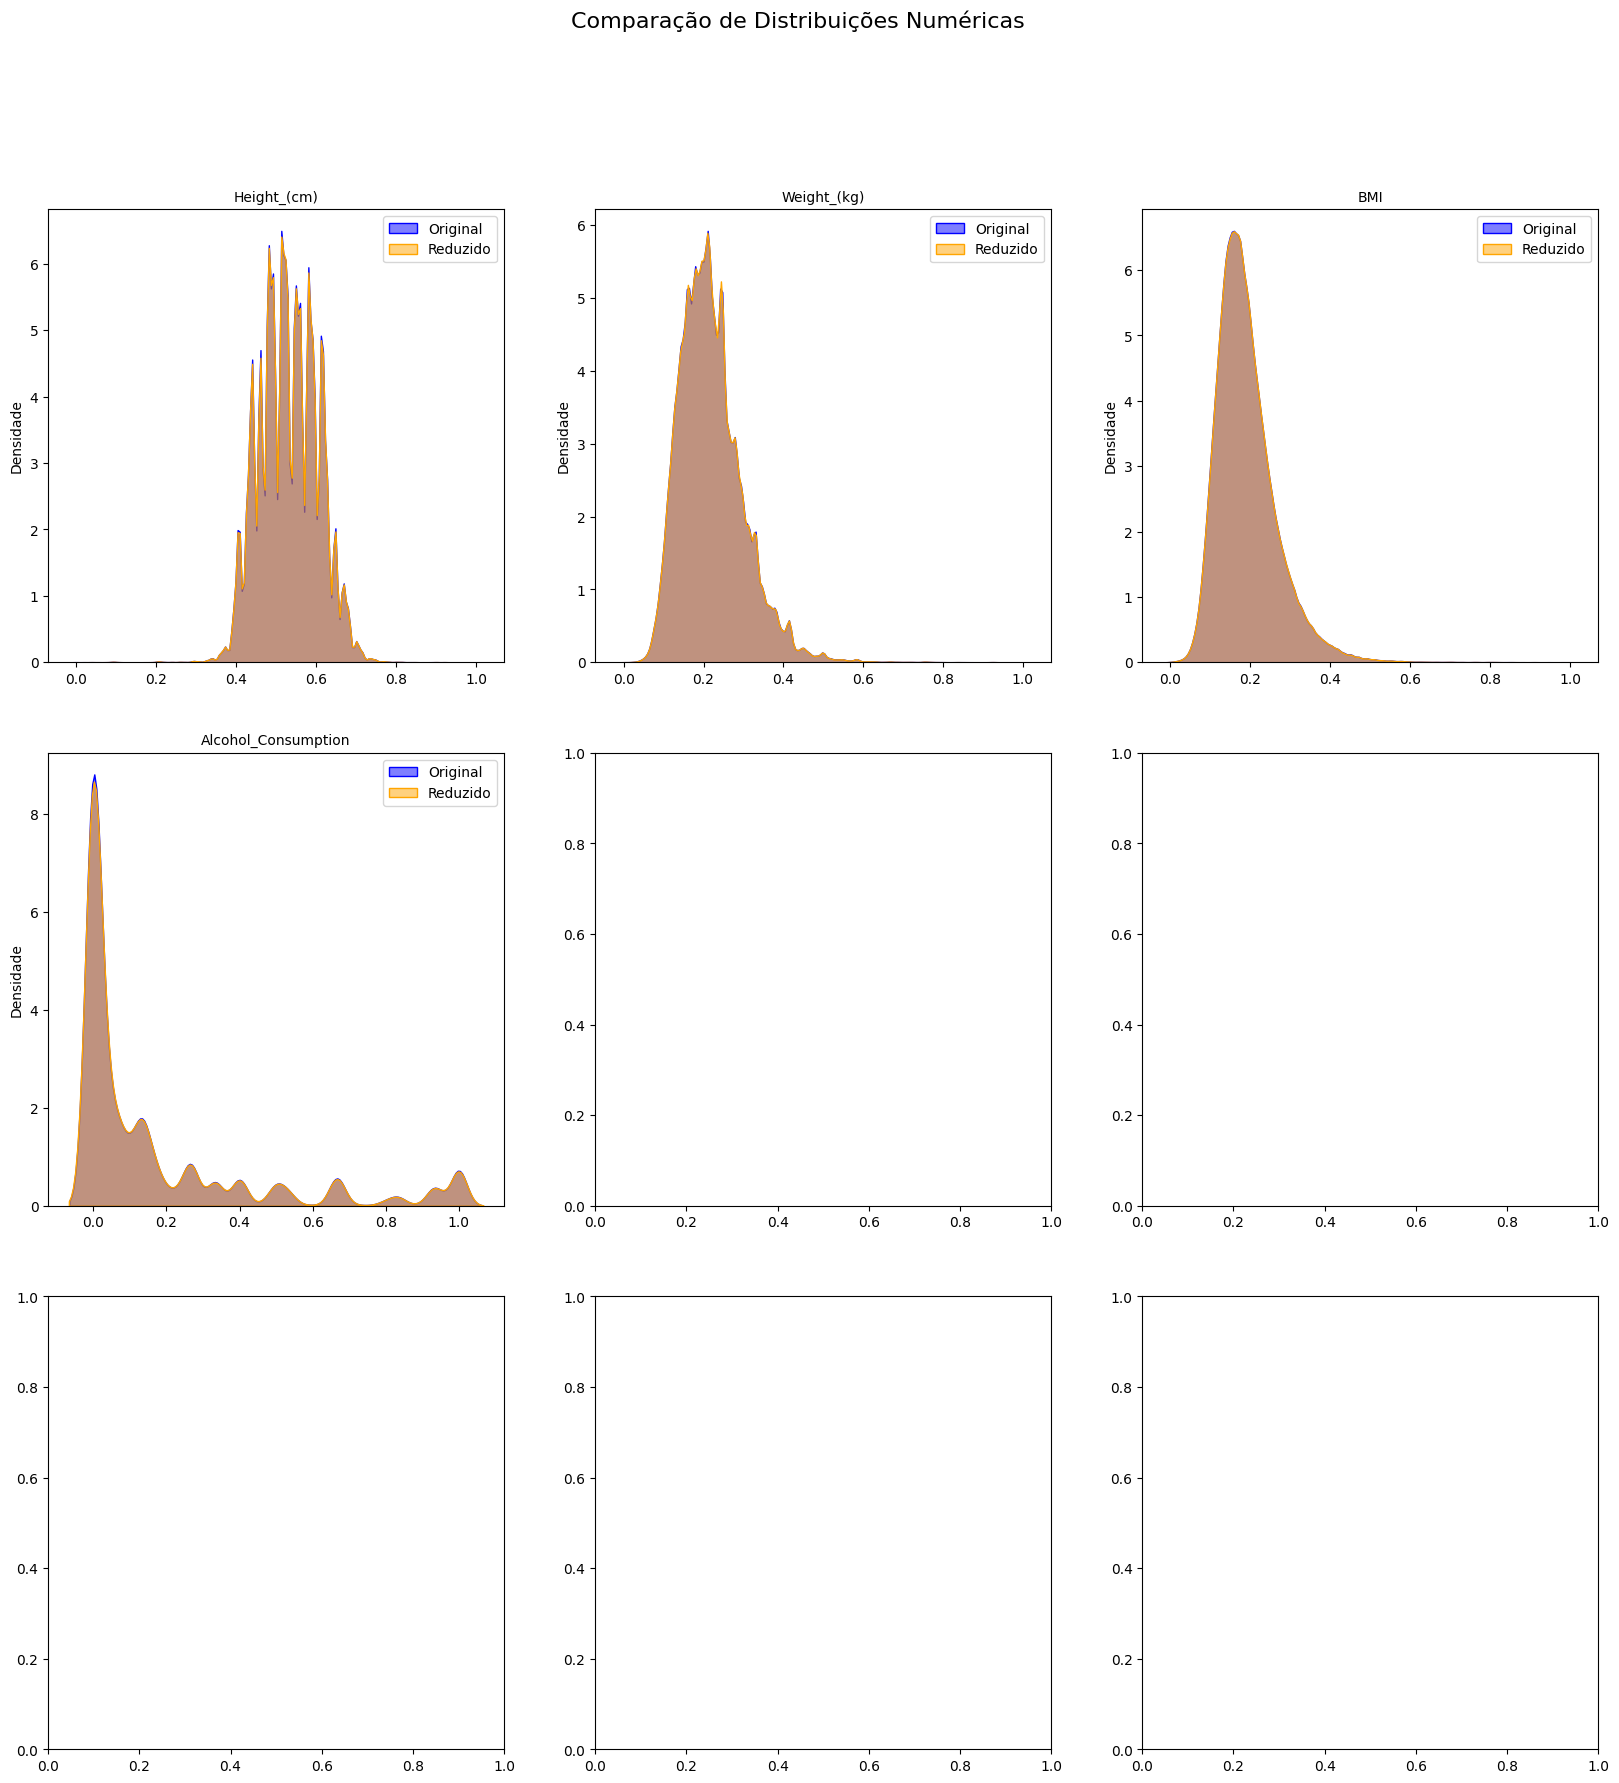

In [63]:
colunas_numericas = cvd_df.select_dtypes(include=['float64']).columns
def comparar_distribuicoes_subplot(df_original, df_reduzido, colunas):
    n_colunas = len(colunas)
    rows, cols = 3, 3  # Layout de subplots
    fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
    fig.suptitle("Comparação de Distribuições Numéricas", fontsize=16)

    axes = axes.flatten()

    for i, col in enumerate(colunas):
        ax = axes[i]

        sns.kdeplot(df_original[col], label='Original', fill=True, color='blue', alpha=0.5, ax=ax)
        sns.kdeplot(df_reduzido[col], label='Reduzido', fill=True, color='orange', alpha=0.5, ax=ax)

        ax.set_title(col, fontsize=10)
        ax.set_xlabel('')
        ax.set_ylabel('Densidade')
        ax.legend()

    for j in range(len(colunas), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
comparar_distribuicoes_subplot(cvd_df, cvd_df_10reduced_imputed, colunas_numericas)

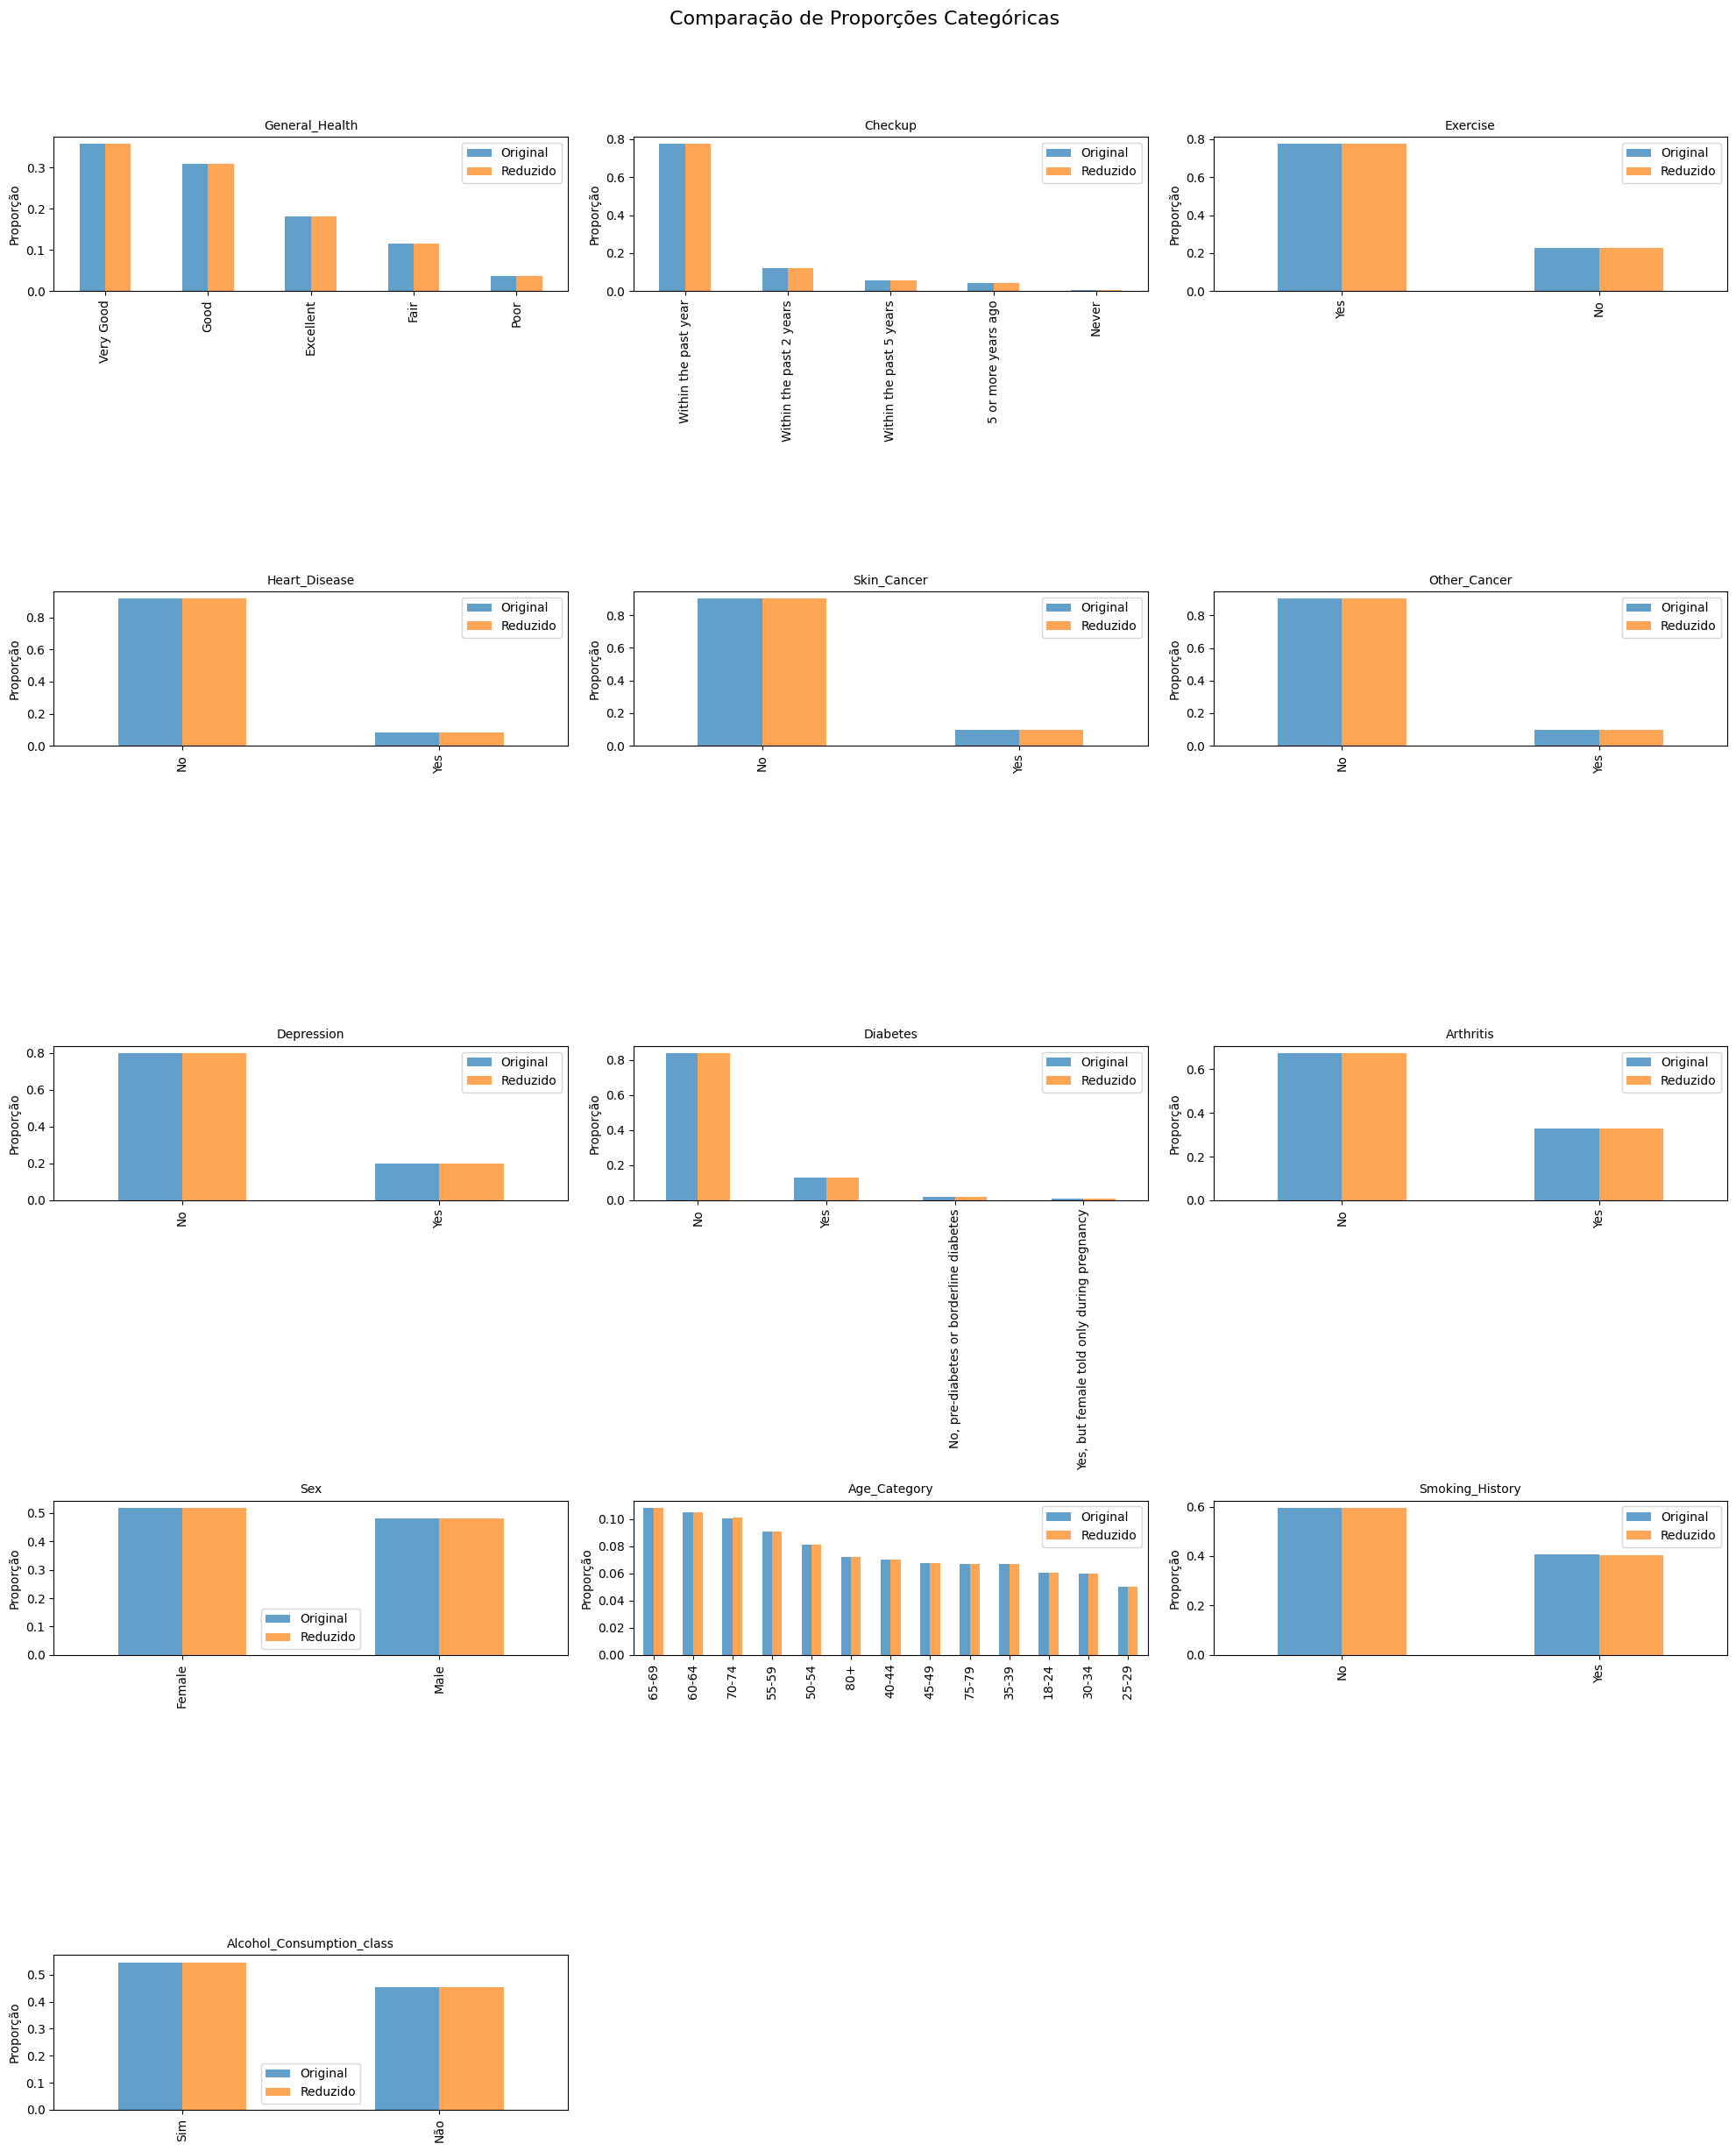

In [ ]:
def comparar_proporcoes_subplot(df_original, df_reduzido, colunas):
    n_colunas = len(colunas)
    rows = (n_colunas // 3) + (1 if n_colunas % 3 != 0 else 0)  # Calcular dinamicamente o número de linhas
    cols = 3  

    fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))
    fig.suptitle("Comparação de Proporções Categóricas", fontsize=16)

    axes = axes.flatten()

    for i, col in enumerate(colunas):
        ax = axes[i]

        prop_original = df_original[col].value_counts(normalize=True)
        prop_reduzido = df_reduzido[col].value_counts(normalize=True)

        prop_df = pd.DataFrame({'Original': prop_original, 'Reduzido': prop_reduzido})
        prop_df.plot(kind='bar', ax=ax, alpha=0.7)

        ax.set_title(col, fontsize=10)
        ax.set_xlabel('')
        ax.set_ylabel('Proporção')
        ax.legend()

    for j in range(len(colunas), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

colunas_categoricas = cvd_df.select_dtypes(include=['object']).columns

comparar_proporcoes_subplot(cvd_df, cvd_df_10reduced_imputed, colunas_categoricas)


### Análise estatística do dataset reduzido em 10% pela estratégia 1


In [ ]:
cvd_df_10reduced_imputed.describe()

,Height_(cm),Weight_(kg),BMI,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
count,277969.000000,277969.000000,277969.000000,277969.000000,277969.000000,277969.000000,277969.000000
mean,0.530777,0.218749,0.190199,0.169640,0.248645,0.118024,0.049146
std,0.071053,0.079557,0.074648,0.273104,0.207385,0.116618,0.066985
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.480000,0.160742,0.139617,0.000000,0.100000,0.031250,0.015625
50%,0.526667,0.211512,0.176612,0.033333,0.250000,0.093750,0.031250
75%,0.580000,0.262245,0.227122,0.200000,0.250000,0.156250,0.062500
max,1.000000,0.930615,1.000000,1.000000,1.000000,1.000000,1.000000


### Dados ausentes do *dataset* reduzido em 20%

In [22]:
dados_removidos = pd.merge(cvd_df, cvd_df_20reduced, how='outer', indicator=True).query('_merge == "left_only"').drop('_merge', axis=1)

colunas_numericas = cvd_df_20reduced.select_dtypes(include=['float64']).columns

for col in colunas_numericas:
    media = cvd_df_20reduced[col].mean()  # Calcular a média da coluna
    cvd_df_10reduced[col] = cvd_df_20reduced[col].fillna(media)  # Substituir valores ausentes pela média

colunas_categoricas = cvd_df_20reduced.select_dtypes(include=['object']).columns

for col in colunas_categoricas:
    moda = cvd_df_20reduced[col].mode()[0]  # Calcular a moda da coluna
    cvd_df_20reduced[col] = cvd_df_20reduced[col].fillna(moda)  # Substituir valores ausentes pela moda


cvd_df_20reduced_imputed = cvd_df_20reduced.copy()

colunas_numericas = cvd_df_10reduced_imputed.select_dtypes(include=['float64']).columns

for col in colunas_numericas:
    media = cvd_df_20reduced_imputed[col].mean()  # Calcular a média da coluna
    cvd_df_20reduced_imputed[col] = cvd_df_20reduced_imputed[col].fillna(media)  # Substituir valores ausentes pela média

colunas_categoricas = cvd_df_10reduced_imputed.select_dtypes(include=['object']).columns

for col in colunas_categoricas:
    moda = cvd_df_10reduced_imputed[col].mode()[0]  # Calcular a moda da coluna
    cvd_df_20reduced_imputed[col] = cvd_df_20reduced_imputed[col].fillna(moda)  # Substituir valores ausentes pela moda






### Análise estatística do dataset reduzido em 20% pela estratégia 1


In [ ]:
cvd_df_20reduced_imputed.describe()

,Height_(cm),Weight_(kg),BMI,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
count,247083.000000,247083.000000,247083.000000,247083.000000,247083.000000,247083.000000,247083.000000
mean,0.530660,0.218576,0.190080,0.169853,0.248620,0.117988,0.049139
std,0.071098,0.079491,0.074562,0.273343,0.207305,0.116503,0.067118
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.480000,0.160742,0.139617,0.000000,0.100000,0.031250,0.015625
50%,0.526667,0.211512,0.176612,0.033333,0.250000,0.093750,0.031250
75%,0.580000,0.262245,0.226435,0.200000,0.250000,0.156250,0.062500
max,1.000000,0.930615,1.000000,1.000000,1.000000,1.000000,1.000000


## Estratégia 2: Remoção de linhas com valores ausentes


### Dados ausentes do *dataset* reduzido em 10%

Encontrar os dados ausentes do *dataset* reduzido em 10%

In [79]:
# Identificar índices das linhas ausentes no DataFrame reduzido
indices_removidos = pd.merge(
    cvd_df.assign(_original_index=cvd_df.index),
    cvd_df_10reduced,
    how="left",
    indicator=True
).query('_merge == "left_only"')['_original_index']


cvd_df_10reduced2 = cvd_df.drop(indices_removidos)


Comparação entre o *dataset* original e o *dataset* reduzido em 10%

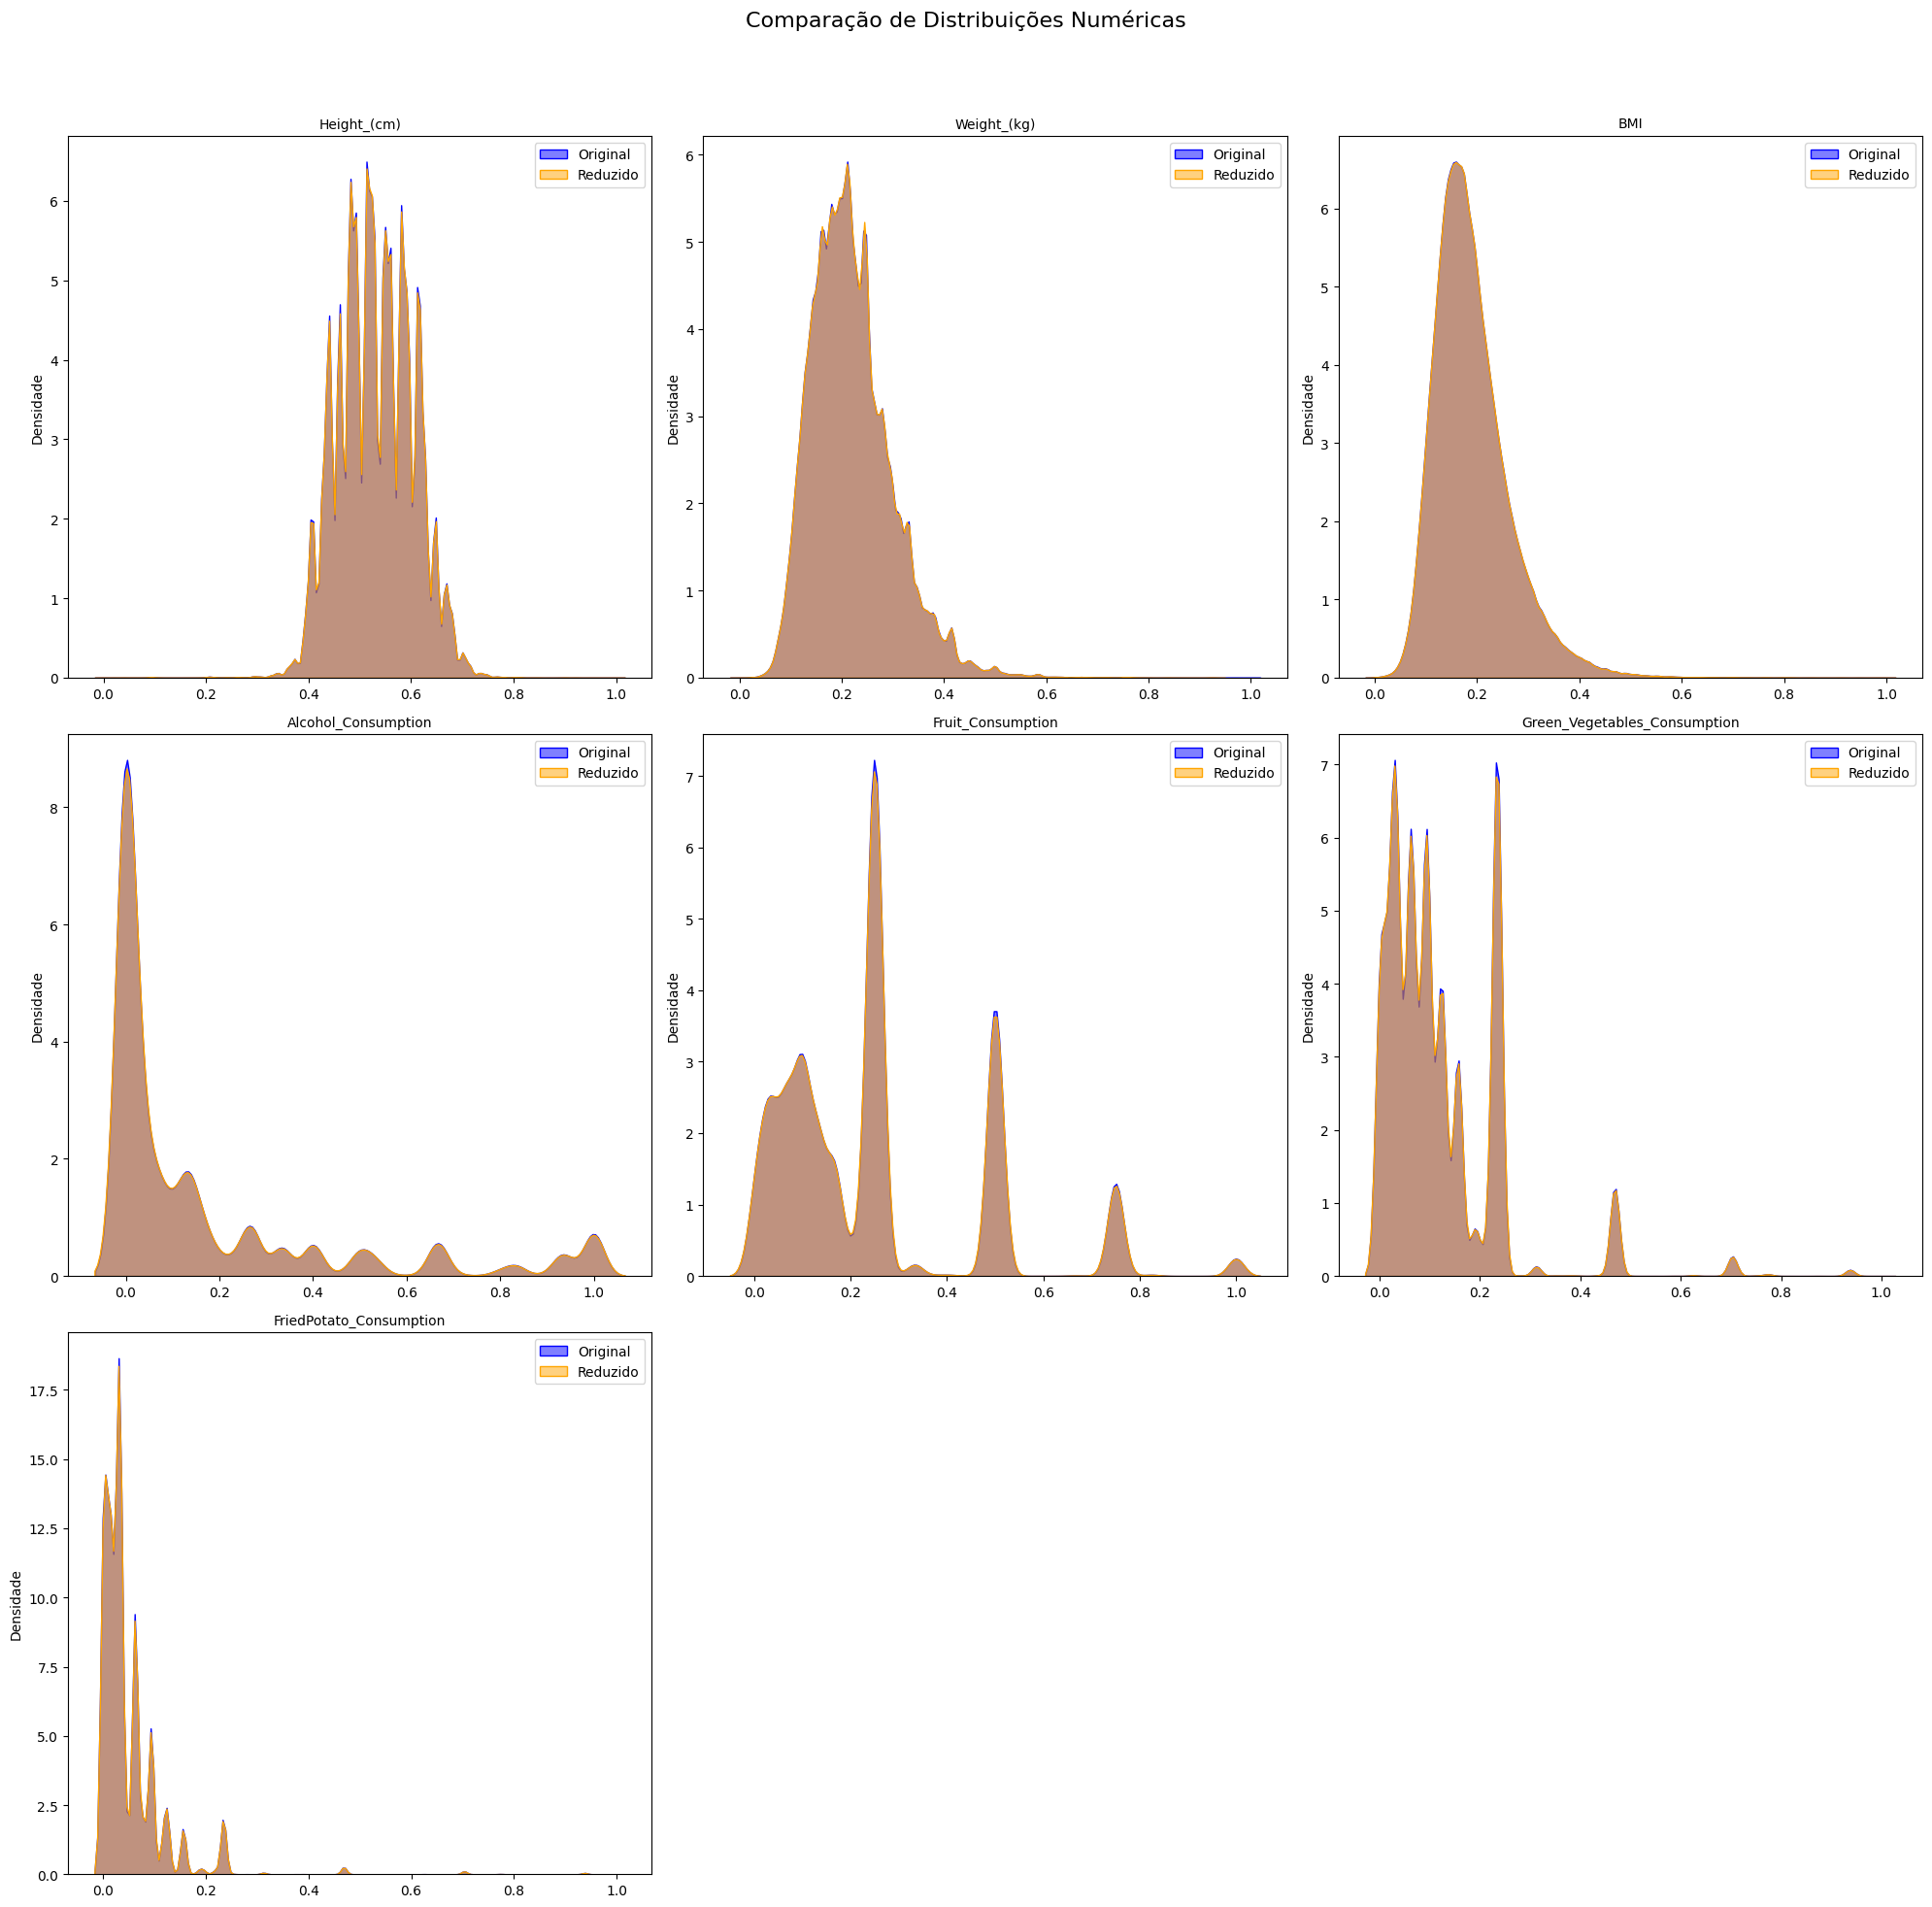

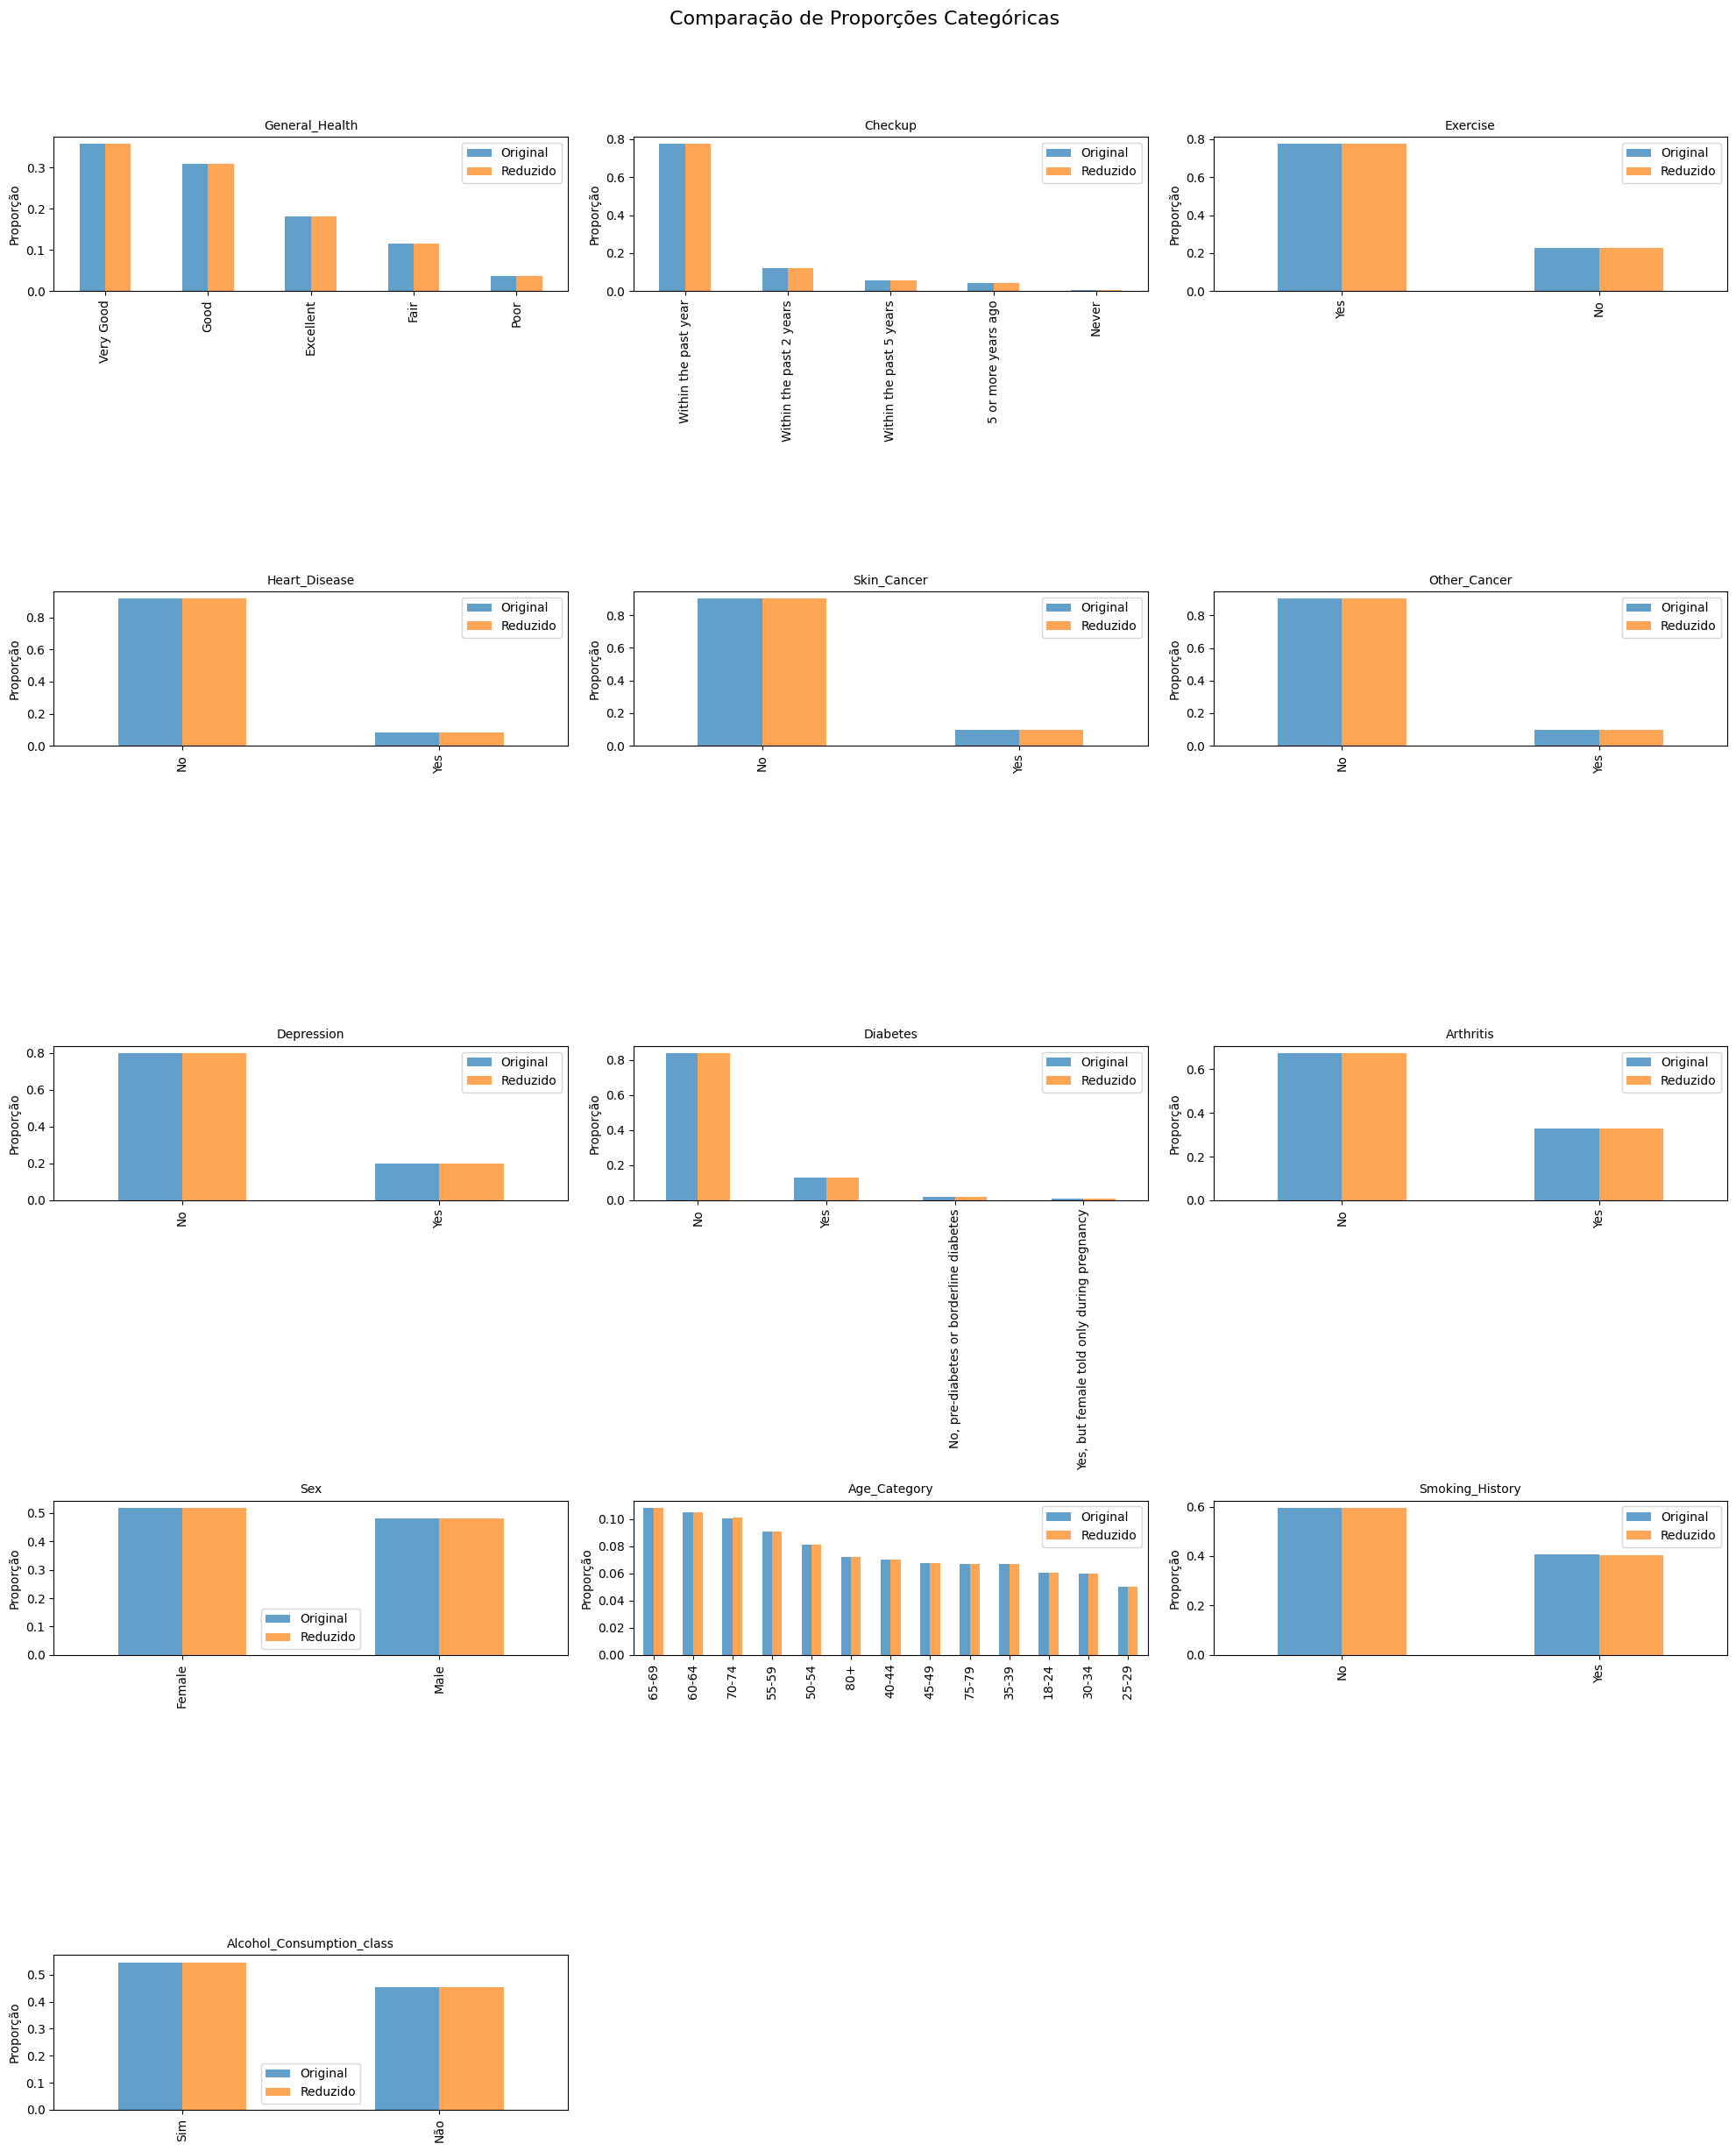

In [80]:
colunas_numericas = cvd_df.select_dtypes(include=['float64']).columns

comparar_distribuicoes_subplot(cvd_df, cvd_df_10reduced2, colunas_numericas)

colunas_categoricas = cvd_df.select_dtypes(include=['object']).columns

comparar_proporcoes_subplot(cvd_df, cvd_df_10reduced2, colunas_categoricas)

### Análise estatística do dataset reduzido em 10% pela estratégia 2


In [81]:
cvd_df_10reduced2.describe()

,Height_(cm),Weight_(kg),BMI,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
count,277985.000000,277985.000000,277985.000000,277985.000000,277985.000000,277985.000000,277985.000000
mean,0.530776,0.218747,0.190198,0.169630,0.248645,0.118025,0.049146
std,0.071052,0.079556,0.074646,0.273099,0.207380,0.116616,0.066983
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.480000,0.160742,0.139617,0.000000,0.100000,0.031250,0.015625
50%,0.526667,0.211512,0.176612,0.033333,0.250000,0.093750,0.031250
75%,0.580000,0.262245,0.227122,0.200000,0.250000,0.156250,0.062500
max,1.000000,0.930615,1.000000,1.000000,1.000000,1.000000,1.000000


Relativamente ao *dataset* original, a variação dos dados nas variáveis Height_(cm), Weight_(kg), BMI e Alcohol_Consumption houve uma diminuição ligeira nos valores do desvio padrão, revelando uma precisão ligeiramente superior. Para as variáveis Fruit_Consumption, Green_Vegetables_Consumption e FriedPotato_Consumption verificou-se o oposto.

### Dados ausentes do *dataset* reduzido em 20%

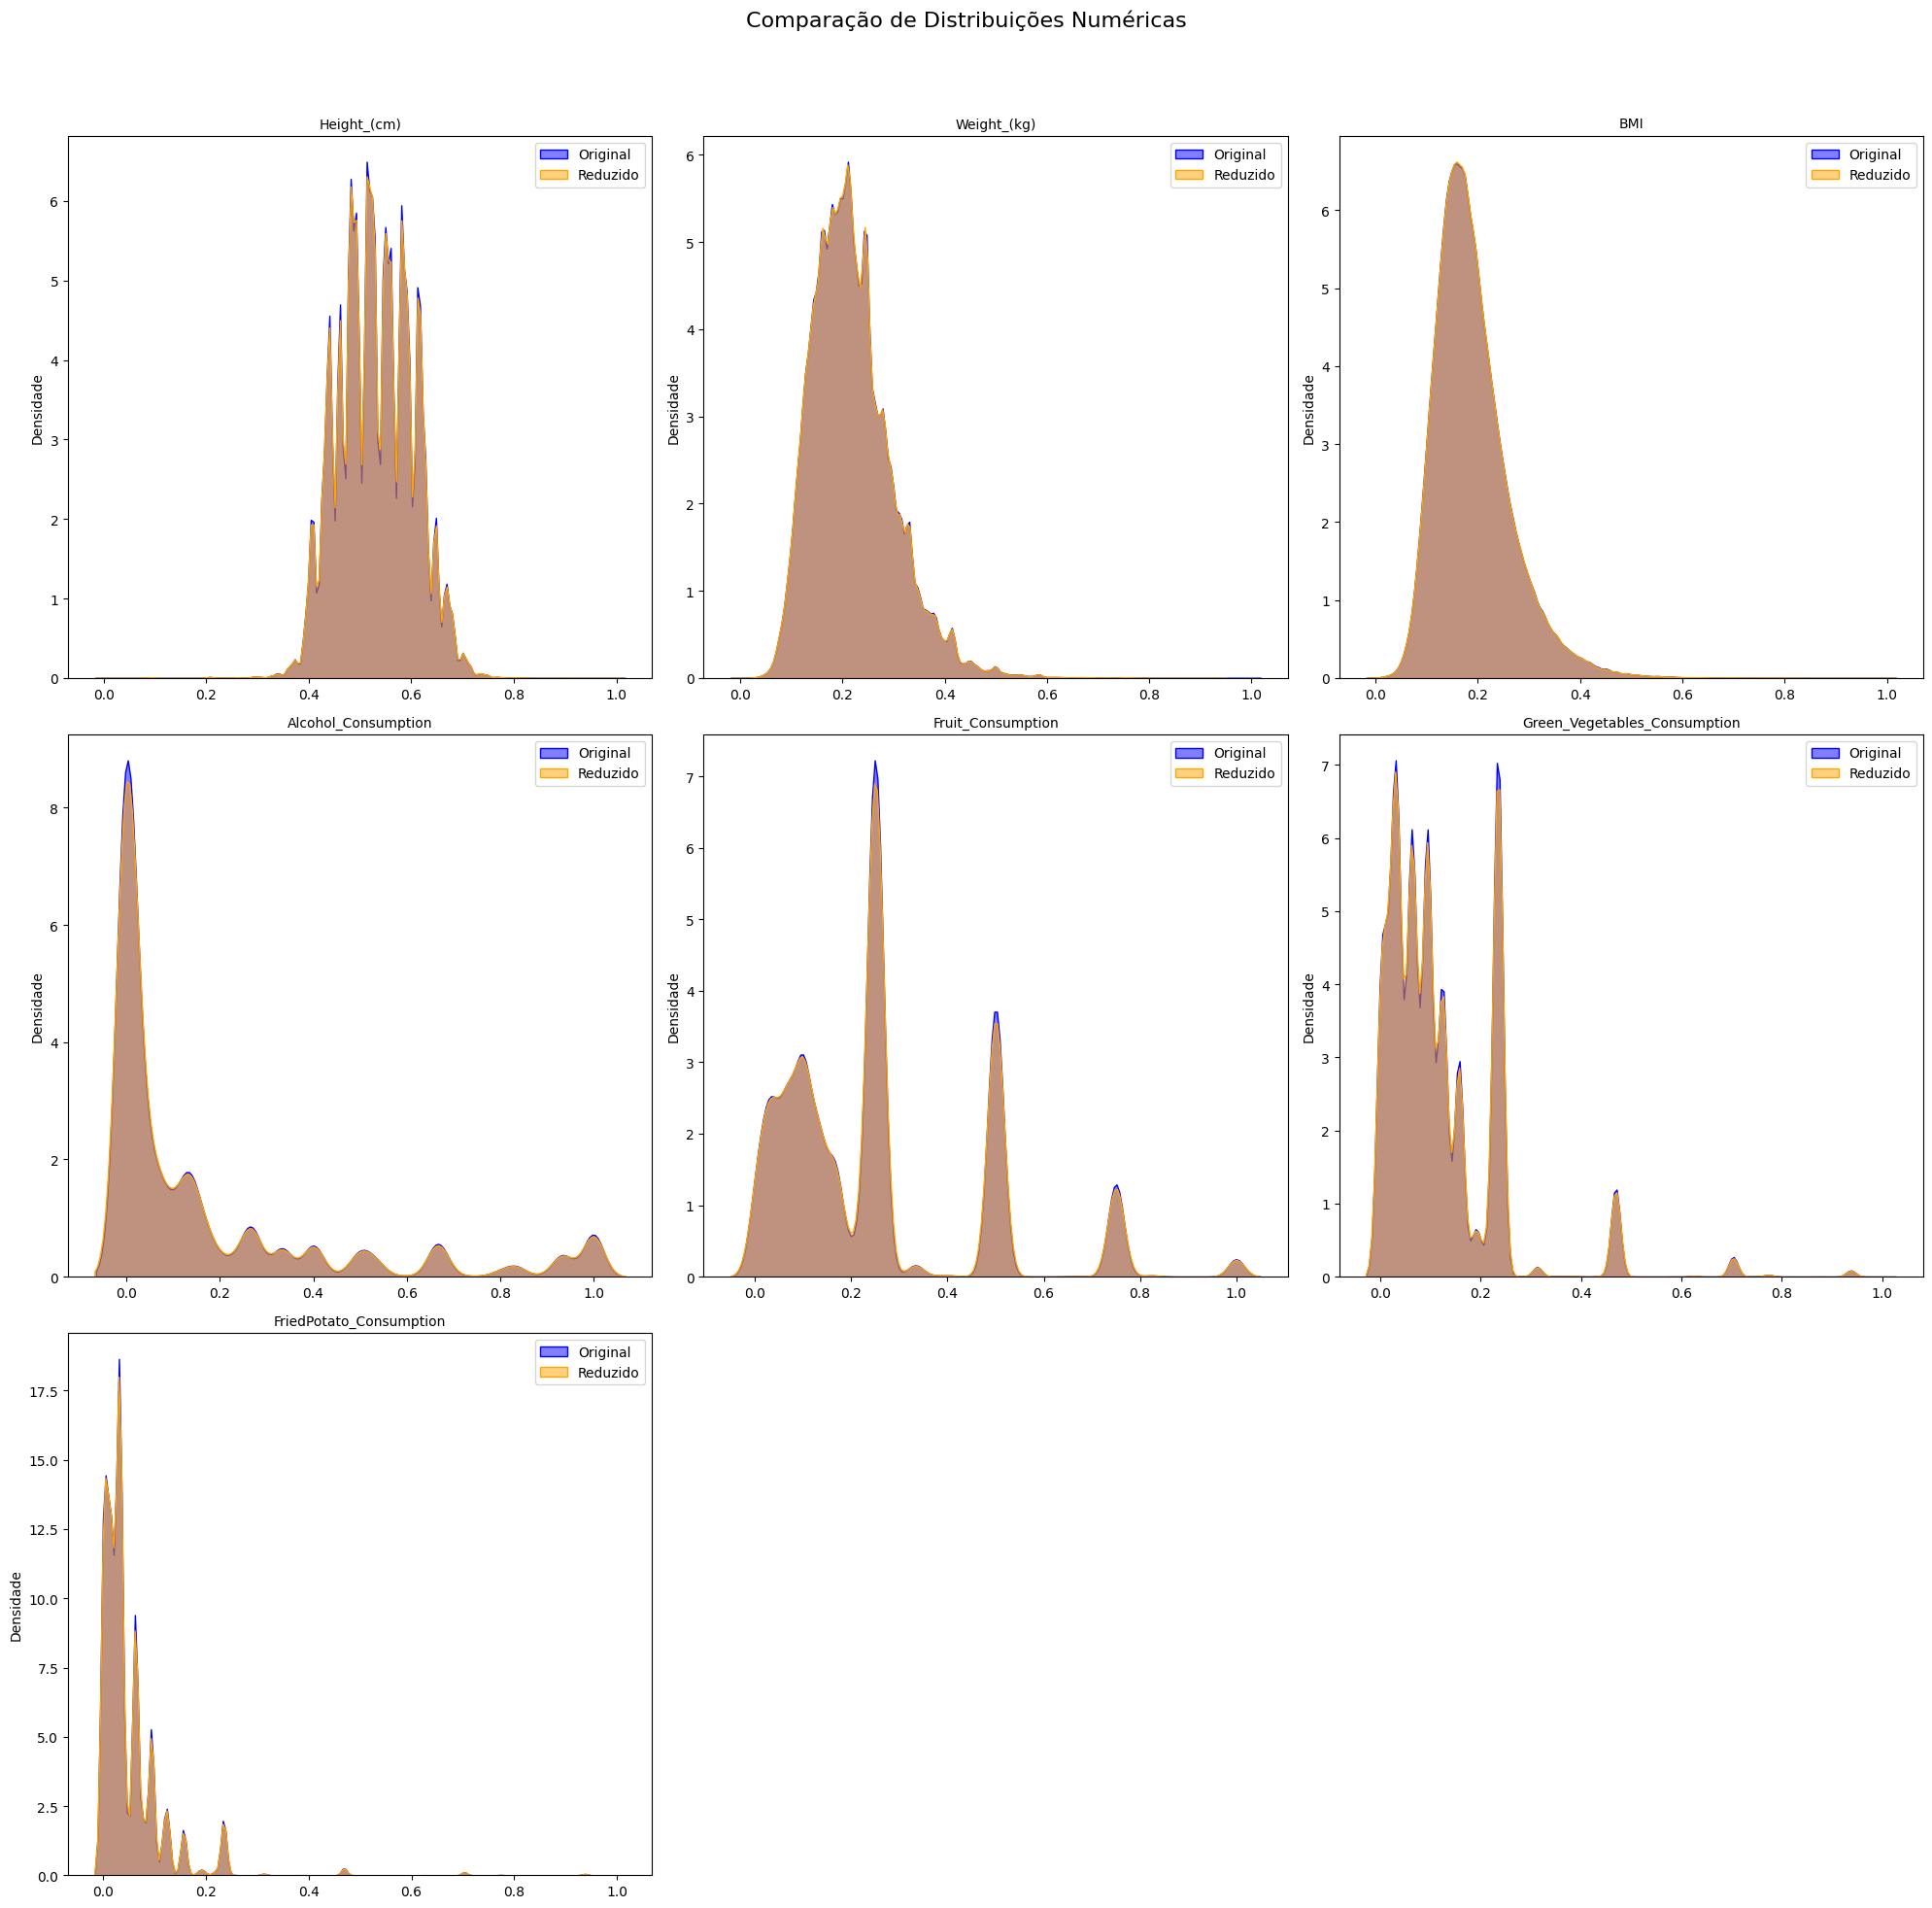

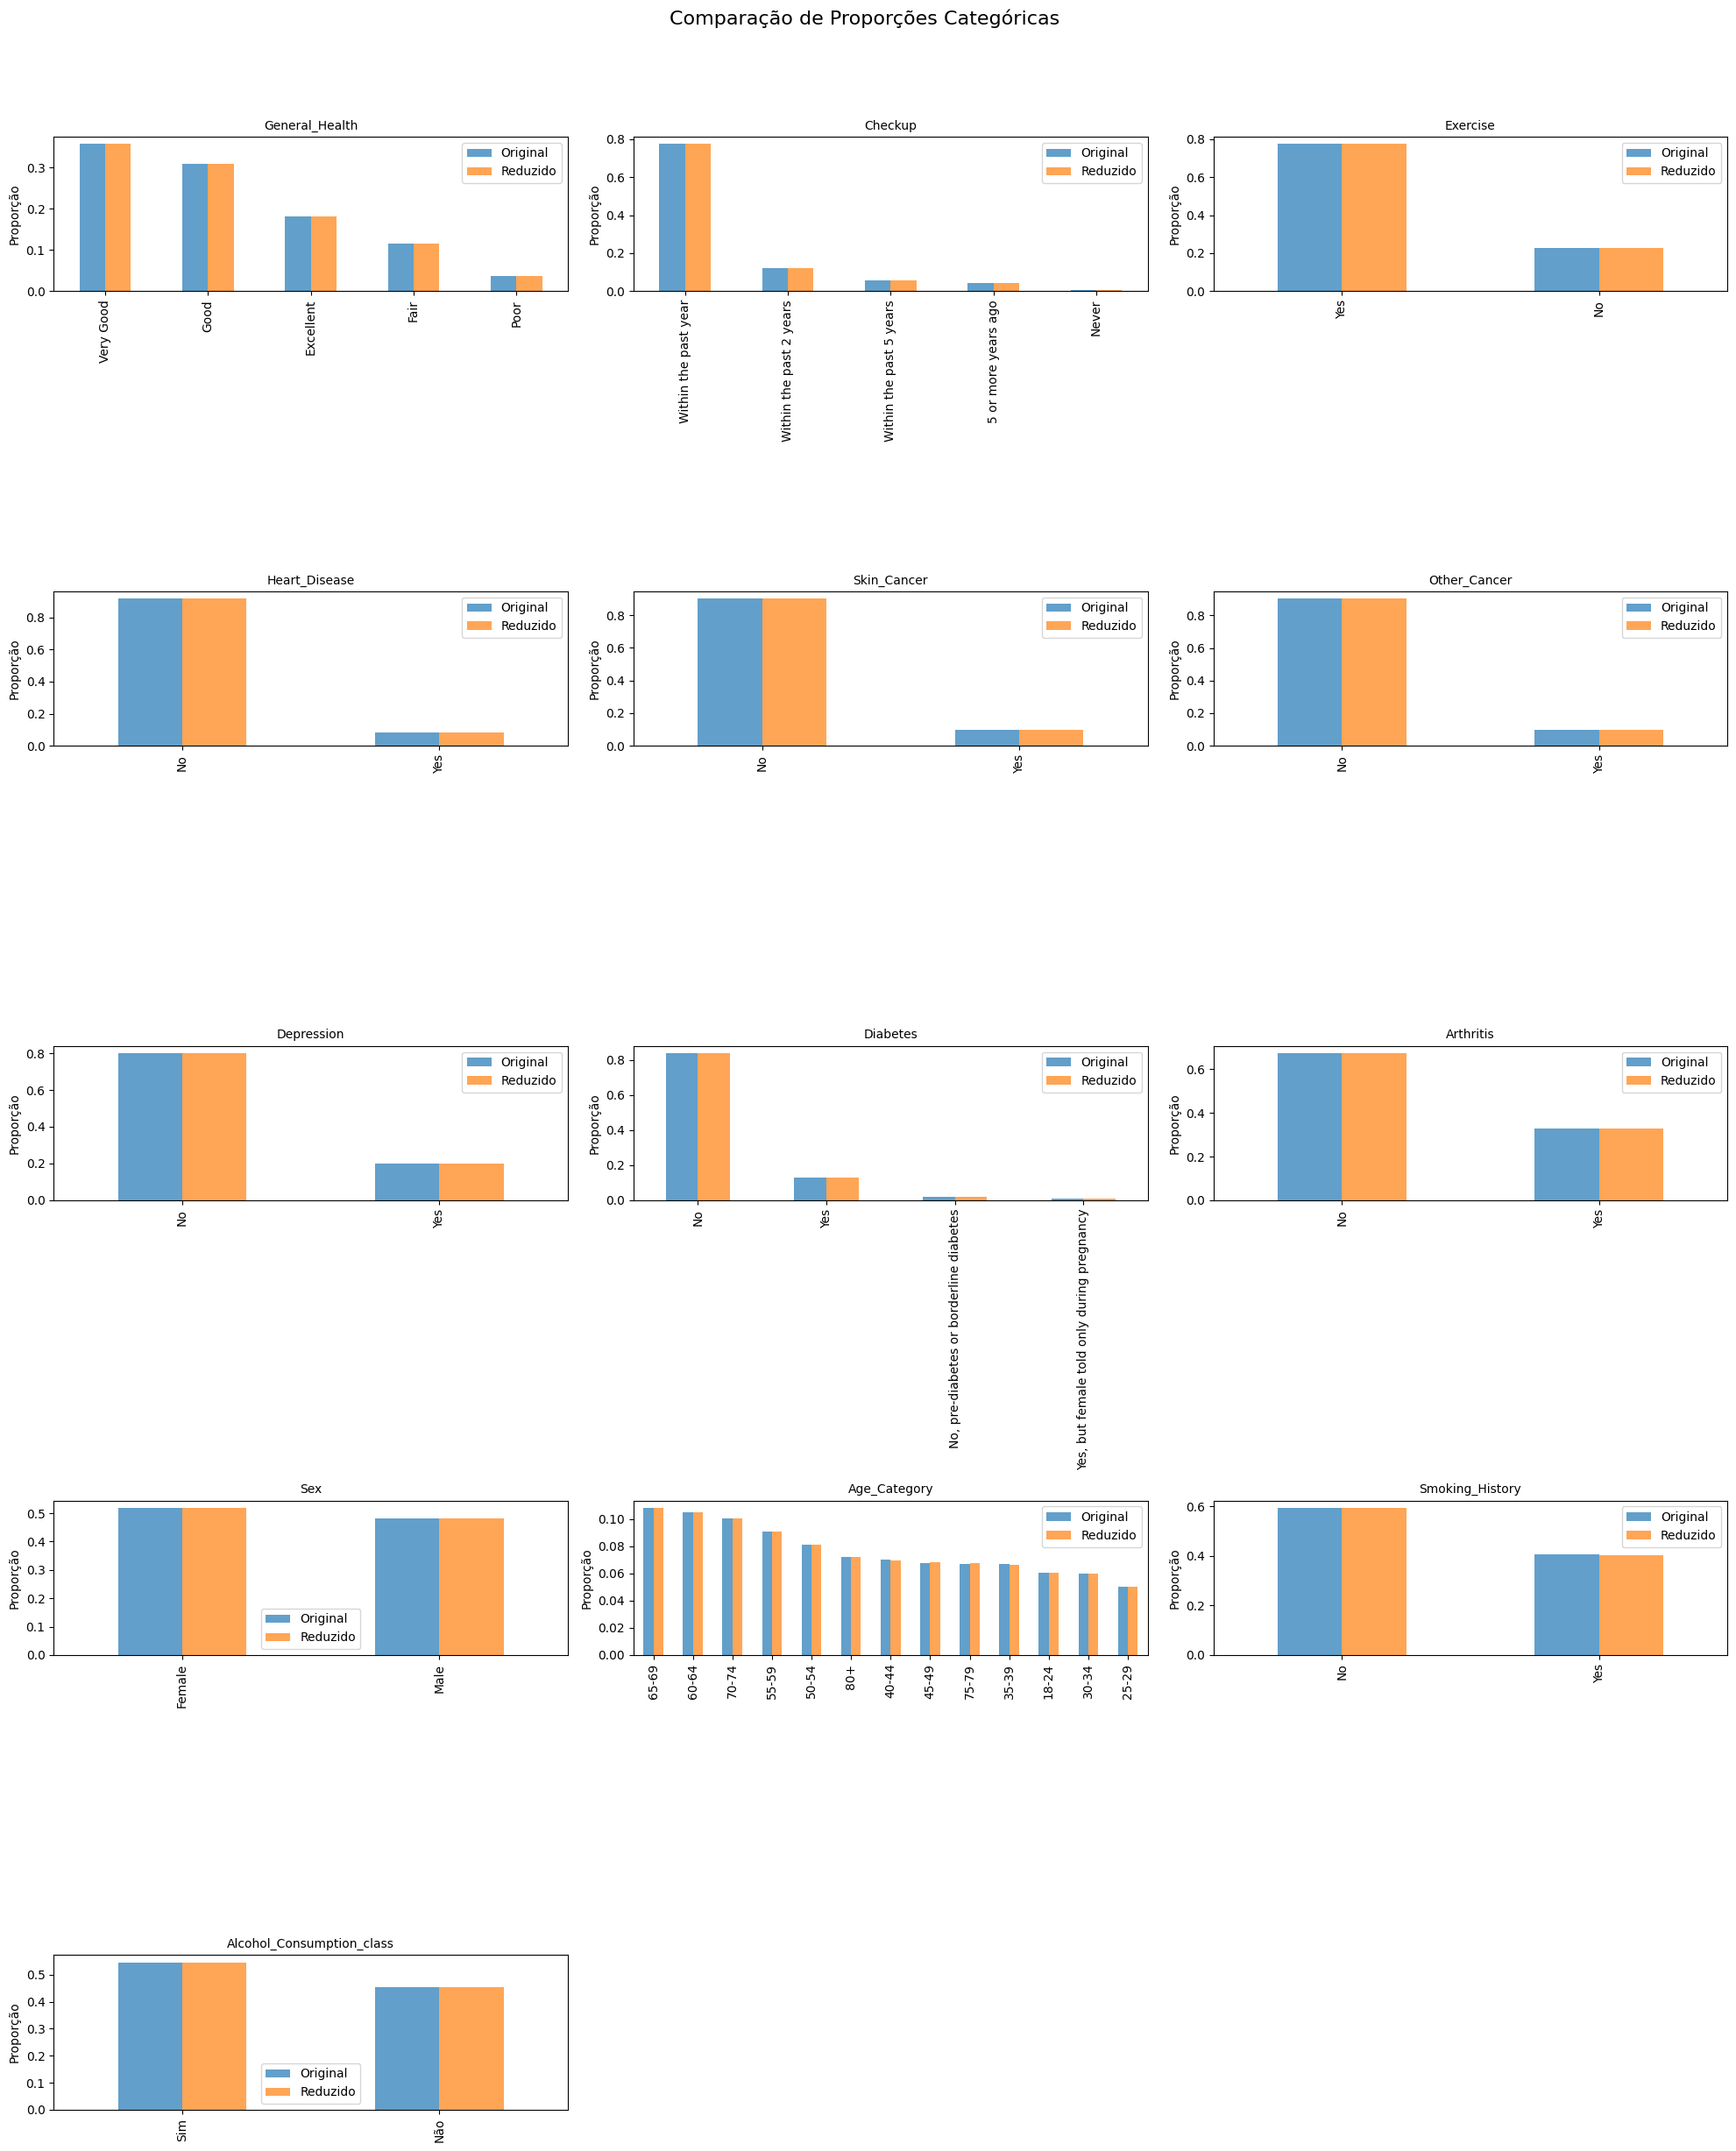

In [82]:
# Identificar índices das linhas ausentes no DataFrame reduzido
indices_removidos = pd.merge(
    cvd_df.assign(_original_index=cvd_df.index),
    cvd_df_20reduced,
    how="left",
    indicator=True
).query('_merge == "left_only"')['_original_index']


cvd_df_20reduced2 = cvd_df.drop(indices_removidos)

colunas_numericas = cvd_df.select_dtypes(include=['float64']).columns

comparar_distribuicoes_subplot(cvd_df, cvd_df_20reduced2, colunas_numericas)

colunas_categoricas = cvd_df.select_dtypes(include=['object']).columns

comparar_proporcoes_subplot(cvd_df, cvd_df_20reduced2, colunas_categoricas)

### Análise estatística do dataset reduzido em 20% pela estratégia 2


In [83]:
cvd_df_20reduced2.describe()

,Height_(cm),Weight_(kg),BMI,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
count,247109.000000,247109.000000,247109.000000,247109.000000,247109.000000,247109.000000,247109.000000
mean,0.530661,0.218574,0.190077,0.169837,0.248625,0.117993,0.049138
std,0.071097,0.079488,0.074559,0.273335,0.207300,0.116501,0.067115
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.480000,0.160742,0.139617,0.000000,0.100000,0.031250,0.015625
50%,0.526667,0.211512,0.176612,0.033333,0.250000,0.093750,0.031250
75%,0.580000,0.262245,0.226320,0.200000,0.250000,0.156250,0.062500
max,1.000000,0.930615,1.000000,1.000000,1.000000,1.000000,1.000000


# **Outliers**

In [84]:
# Função para remover outliers usando IQR
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Remover outliers de todas as colunas numéricas
cvd_df_10reduced_no_outliers = remove_outliers(cvd_df_10reduced, numerical_cols)

cvd_df_10reduced_no_outliers.describe()

,Height_(cm),Weight_(kg),BMI,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
count,167353.000000,167353.000000,167353.000000,167353.000000,167353.000000,167353.000000,167353.000000
mean,0.529206,0.212193,0.184078,0.089879,0.153918,0.093224,0.038178
std,0.069149,0.067000,0.059607,0.135571,0.090753,0.075008,0.033231
min,0.340000,0.025367,0.015233,0.000000,0.000000,0.000000,0.000000
25%,0.480000,0.160742,0.140992,0.000000,0.066667,0.031250,0.015625
50%,0.526667,0.211512,0.176841,0.000000,0.133333,0.078125,0.031250
75%,0.580000,0.253814,0.222655,0.133333,0.250000,0.125000,0.062500
max,0.726667,0.414257,0.345436,0.566667,0.466667,0.343750,0.132812


Usamos IQR para remover outliers das classes numericas, no Data Understanding verificamos muitos outliers em varias classes.